# Etape 2 - Exploration des données (y compris préprocessing)

In [129]:
# Import librairies
import os
import re
import pandas as pd
import nltk
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from utils_text_processing import *

In [130]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "\\data"
output_path = path + "\\outputs"
fig_path = path + "\\figures"

In [131]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [132]:
# Autorisation pour la visualisation par pyLDAvis
pyLDAvis.enable_notebook()

In [133]:
# Paramètres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)
dpi = 300

In [134]:
# Import des données
df = pd.read_csv(os.path.join(data_path, "working_data.csv"), index_col=0)
print(f"le Fichier de données contient {df.shape[0]} lignes et  {df.shape[1]} colonnes")

le Fichier de données contient 89416 lignes et  8 colonnes


In [135]:
# Visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,DDC,TEF_LABEL
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,840.0,Littérature de langues romanes. Littérature fr...
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",150.0,Psychologie
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",840.0,Littérature de langues romanes. Littérature fr...
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",100.0,"Philosophie, psychologie"
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,830.0,Littérature allemande


## Exploration des mots-clé RAMEAU

In [136]:
df.loc[1:10, "RAMEAU"]

1             Complexe de castration;Psychanalyse;Rêves
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Agglomérations urbaines;Aménagement du territo...
7                     Tarots (cartes à jouer) -- Contes
8     Allégorie de la caverne;Différences entre sexe...
9     Attachement;Mères et nourrissons;Personnalité ...
10                  Philosophes;Philosophie et sciences
Name: RAMEAU, dtype: object

In [137]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU => i.e chaines d'indexation
df["test_tiret"] = df["RAMEAU"].apply(lambda x: True if re.search(' -- ', x) else False)
df.loc[df["test_tiret"]==True, ["PPN", "RAMEAU"]]

,PPN,RAMEAU
4,000026352,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...
11,000049719,Civilisation -- Histoire
18,000062995,Professeurs des écoles -- Formation;Écoles nor...
...,...,...
89402,268319014,Art chrétien -- Peinture
89405,268334846,Préparation au mariage -- Église catholique
89412,268363072,Aliments -- Ouvrages pour la jeunesse;Pois (lé...
89414,268365334,Droit pénal;Sécurité sociale -- Droit -- Dispo...


=> 39141 notices avec des chaines d'indexation

In [138]:
# Extraction des chaines d'indexation
df["rameau_list"] = df["RAMEAU"].apply(lambda x: x.split(';'))
print(df.loc[1:10, "rameau_list"])

1         [Complexe de castration, Psychanalyse, Rêves]
2                                             [Culture]
3                                      [Structuralisme]
4     [Science-fiction américaine -- Traductions fra...
5                                        [Photographie]
6     [Agglomérations urbaines, Aménagement du terri...
7                   [Tarots (cartes à jouer) -- Contes]
8     [Allégorie de la caverne, Différences entre se...
9     [Attachement, Mères et nourrissons, Personnali...
10               [Philosophes, Philosophie et sciences]
Name: rameau_list, dtype: object


In [139]:
rameau_list = df["rameau_list"].tolist()
type(rameau_list)

list

In [140]:
# Nombre de chaines d'indexation différentes
from itertools import chain
rameau_lists = df["rameau_list"].tolist()
rameau_list = list(chain(*rameau_lists))
print(f"{len(rameau_list)} chaines d'indexation, dont {len(set(rameau_list))} uniques")

200405 chaines d'indexation, dont 52441 uniques


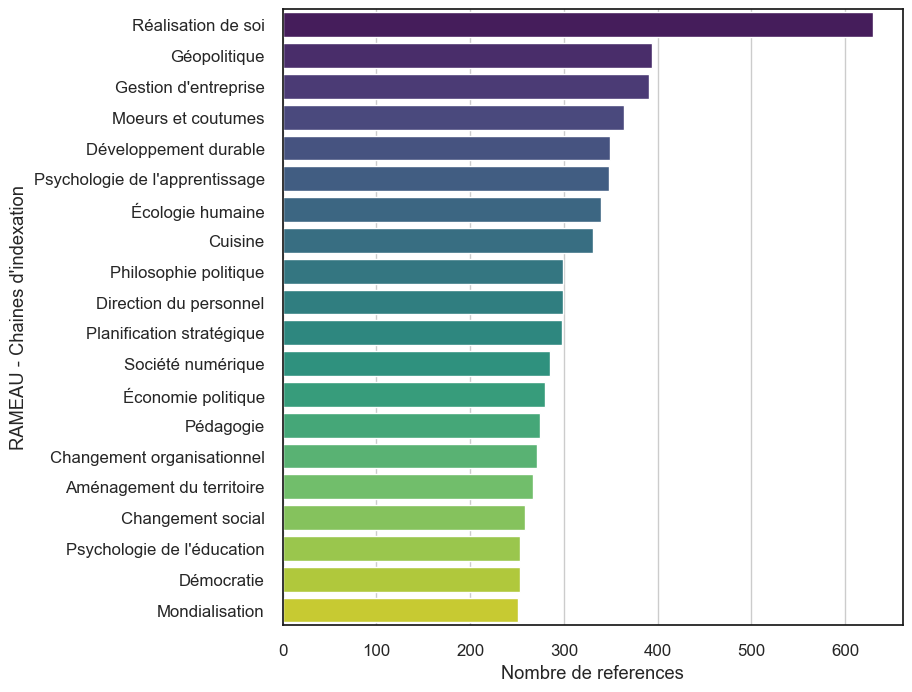

In [141]:
plot_barplot_of_tags(
    tags_list=rameau_list,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Chaines d'indexation",
    figsave=os.path.join(fig_path, 'barplot_Rameau_chaines_index.png'),
    figsize=(8, 8))

In [142]:
# Mettre à plat TOUS les mots clé
df["rameau_list_unstack"] = df["RAMEAU"].apply(lambda x: re.split(r';| -- ', x))
df.loc[1:10, "rameau_list_unstack"]

1         [Complexe de castration, Psychanalyse, Rêves]
2                                             [Culture]
3                                      [Structuralisme]
4     [Science-fiction américaine, Traductions franç...
5                                        [Photographie]
6     [Agglomérations urbaines, Aménagement du terri...
7                     [Tarots (cartes à jouer), Contes]
8     [Allégorie de la caverne, Différences entre se...
9     [Attachement, Mères et nourrissons, Personnali...
10               [Philosophes, Philosophie et sciences]
Name: rameau_list_unstack, dtype: object

In [143]:
flatten(df.loc[1:10, 'rameau_list_unstack'])

['Complexe de castration',
 'Psychanalyse',
 'Rêves',
 'Culture',
 'Structuralisme',
 'Science-fiction américaine',
 'Traductions françaises',
 'Photographie',
 'Agglomérations urbaines',
 'Aménagement du territoire',
 'Migrations intérieures',
 'Périurbanisation',
 'Relations villes-campagnes',
 'Tarots (cartes à jouer)',
 'Contes',
 'Allégorie de la caverne',
 'Différences entre sexes (psychologie)',
 'Féminité',
 'Psychanalyse et femmes',
 'Sexualité (psychologie)',
 'Sexualité féminine',
 'Attachement',
 'Mères et nourrissons',
 'Personnalité',
 "Chez l'enfant",
 'Philosophes',
 'Philosophie et sciences']

In [144]:
keywords = flatten(df['rameau_list_unstack'])
keywords

['Culture populaire',
 'Diffusion de la culture',
 'Politique culturelle',
 'Complexe de castration',
 'Psychanalyse',
 'Rêves',
 'Culture',
 'Structuralisme',
 'Science-fiction américaine',
 'Traductions françaises',
 'Photographie',
 'Agglomérations urbaines',
 'Aménagement du territoire',
 'Migrations intérieures',
 'Périurbanisation',
 'Relations villes-campagnes',
 'Tarots (cartes à jouer)',
 'Contes',
 'Allégorie de la caverne',
 'Différences entre sexes (psychologie)',
 'Féminité',
 'Psychanalyse et femmes',
 'Sexualité (psychologie)',
 'Sexualité féminine',
 'Attachement',
 'Mères et nourrissons',
 'Personnalité',
 "Chez l'enfant",
 'Philosophes',
 'Philosophie et sciences',
 'Civilisation',
 'Histoire',
 'Interprétation psychanalytique',
 'Psychanalyse et littérature',
 'Géographie humaine',
 'Technique et civilisation',
 'Urbanisme',
 'Écologie',
 'Discrimination sexuelle',
 'Intégration sociale',
 'Philosophie de la Renaissance',
 'Mathématiques économiques',
 'Théorie des j

In [145]:
len(set(keywords))

21410

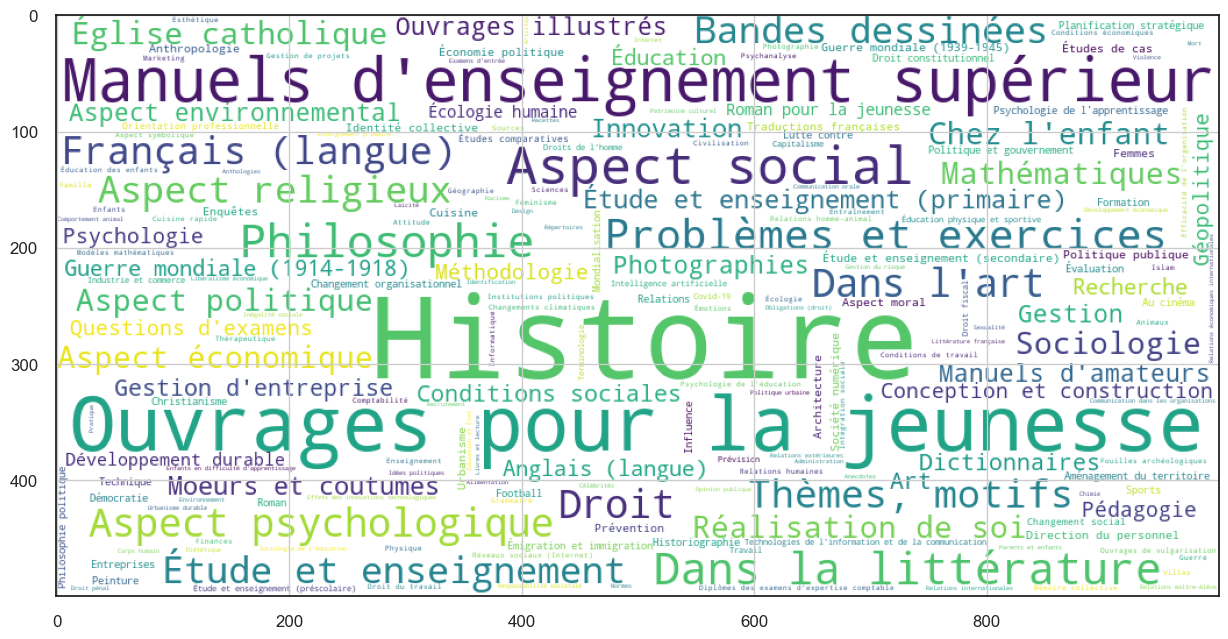

In [146]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(keywords))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

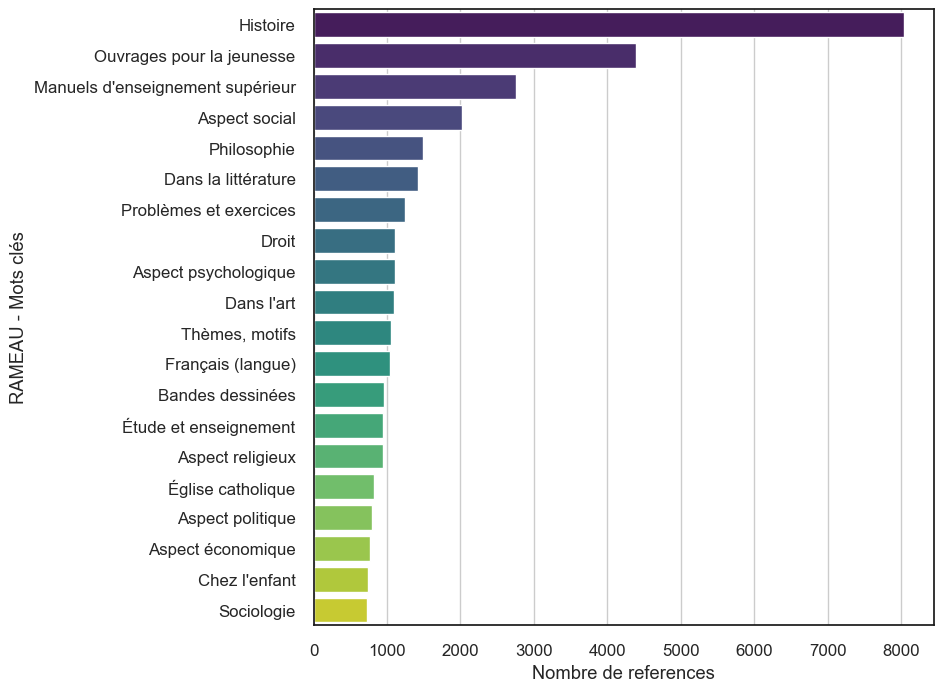

In [147]:
plot_barplot_of_tags(
    tags_list=keywords,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords_unstack.png',
    figsize=(8, 8))

# Exploration des domaines DDC

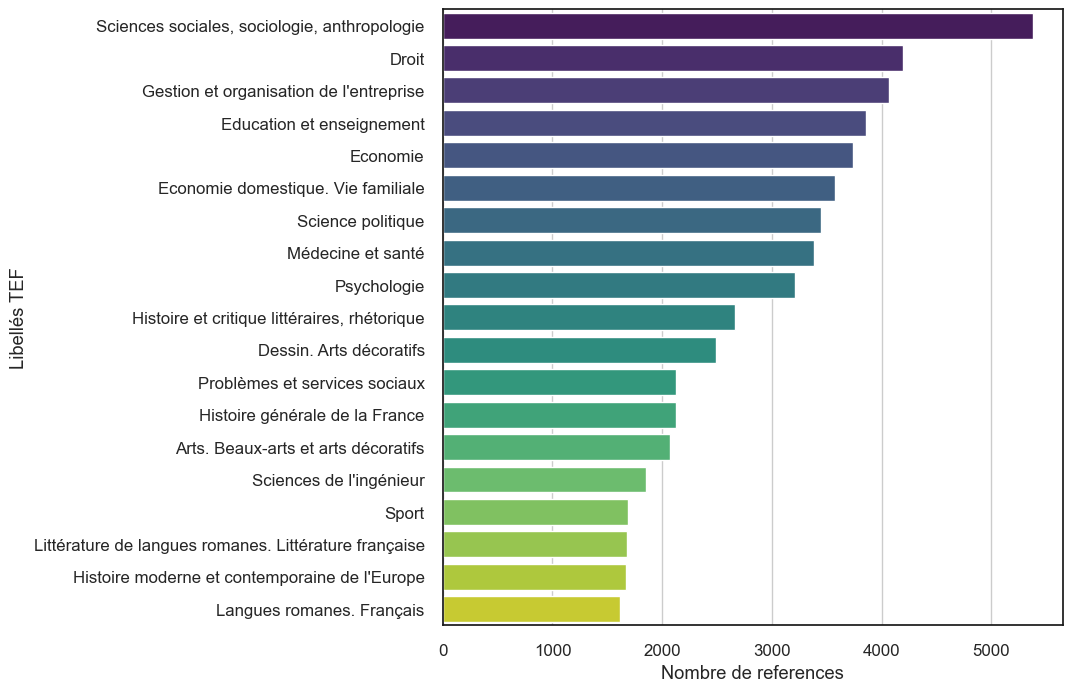

In [148]:
plot_barplot_of_tags(
    tags_list=df["TEF_LABEL"],
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="Libellés TEF",
    figsave='figures/barplot_libelles_TEF.png',
    figsize=(8, 8))

In [150]:
df[df["TEF_LABEL"] == "Sciences sociales, sociologie, anthropologie"].shape

(5382, 11)

In [151]:
df[df["TEF_LABEL"] == "Droit"].shape

(4195, 11)

In [152]:
df[df["TEF_LABEL"] == "Sport"].shape

(1689, 11)

## Exploration des titres

In [91]:
list(set(stopwords.words("french")))

['avec',
 'ait',
 't',
 'êtes',
 'étées',
 'ou',
 'je',
 'étiez',
 'aurait',
 'eut',
 'les',
 'ayons',
 'ayantes',
 'me',
 'eues',
 'tu',
 'avaient',
 'ma',
 'aurions',
 'est',
 'auront',
 'qu',
 'aviez',
 'avions',
 'tes',
 'm',
 'sont',
 'ce',
 'aurez',
 'ayante',
 'serons',
 'serez',
 'on',
 'fussent',
 'seraient',
 'eus',
 'sur',
 'avais',
 'nos',
 'fus',
 'fût',
 'pas',
 'soyez',
 'eu',
 'eusse',
 'pour',
 'eûmes',
 'aurai',
 'sommes',
 'auriez',
 's',
 'aurons',
 'eurent',
 'es',
 'ta',
 'eûtes',
 'mais',
 'avons',
 'en',
 'étée',
 'étions',
 'eussions',
 'auraient',
 'fussiez',
 'ton',
 'eussiez',
 'seront',
 'dans',
 'ne',
 'serais',
 'notre',
 'ai',
 'auras',
 'étés',
 'des',
 'avait',
 'était',
 'eue',
 'sera',
 'il',
 'seriez',
 'avez',
 'étaient',
 'étante',
 'à',
 'aux',
 'mes',
 'ses',
 'ayants',
 'aie',
 'eux',
 'leur',
 'j',
 'furent',
 'toi',
 'étant',
 'aies',
 'vous',
 'serions',
 'aient',
 'été',
 'la',
 'du',
 'étais',
 'fut',
 'd',
 'suis',
 'le',
 'étantes',
 'so

In [92]:
# Test function
idx = 1045
text = df.loc[idx, 'TITRE']
print(text)

Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie


In [93]:
doc = nlp("Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie" )
empty_list = []
for token in doc:
    empty_list.append(token.lemma_)

final_string = ' '.join(map(str,empty_list))
print(final_string)

éloge de le folie : adage : colloque : Réflexions sur le éducation , le religion , le guerre , le philosophie


In [94]:
doc = nlp("Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie" )
doc

Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie

In [95]:
# add words
add_words = [
        "la",
        "de",
        "le",
        "les",
        "l",
        "au",
        "du"
]


preprocess_text(
        text, add_words,
        numeric=False, stopw=True,
        stem=False, lem=True)

'éloge folie adage colloque réflexion éducation religion guerre philosophi'

In [96]:
# Test sur un échantillon de notices
df_sample = df.sample(n=20000)

In [97]:
df_sample.shape

(20000, 9)

In [98]:
# Preprocess titres
df_sample['TITRE_processed'] = df_sample['TITRE'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

In [107]:
# Exemple
idx = 300
print("Titre brut: \n", df_sample['TITRE'].iloc[idx])
print("\nTitre après processing :\n", df_sample['TITRE_processed'].iloc[idx])

Titre brut: 
 Mouvements protestataires et luttes populaires en France (1831-1968)

Titre après processing :
 mouvement protestataire lutte populaire france 1831 1968


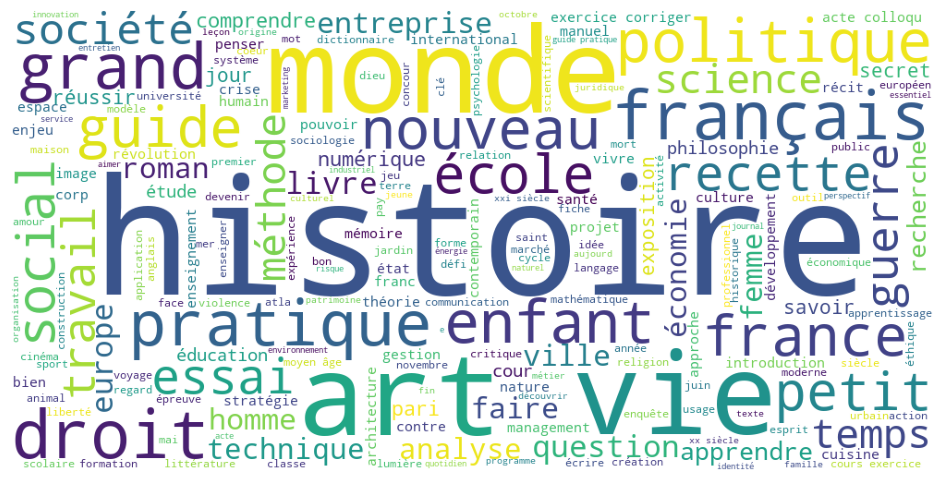

In [108]:
plot_wordcloud(df_sample['TITRE_processed'])

### Exploration des topics (pyLDAvis)

In [109]:
# Vectorization
feature = 'TITRE_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df_sample[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (20000, 300)


In [110]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [111]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.153995 -0.193427       1        1  9.283328
6     -0.091275 -0.155094       2        1  8.872184
14    -0.016816  0.135045       3        1  7.736160
5     -0.021828  0.136220       4        1  7.390825
11     0.328791 -0.114204       5        1  7.375341
3     -0.076532  0.025180       6        1  7.292878
7     -0.020247  0.114420       7        1  6.346842
8     -0.151026 -0.264663       8        1  6.262808
9     -0.043066  0.081150       9        1  6.221332
12     0.086069  0.035956      10        1  6.183592
0     -0.023774  0.108566      11        1  5.795485
4     -0.021079  0.104297      12        1  5.791647
13    -0.052726  0.009144      13        1  5.606475
10    -0.019194  0.084370      14        1  5.105704
1      0.276699 -0.106959      15        1  4.735398, topic_info=          Term        Freq       Total Category  logprob  loglift
138   histoire  497.000000  497.000000  Default  30.0000  30.0000
90       droit  341.000000  341.000000  Default  29.0000  29.0000
186      monde  303.000000  303.000000  Default  28.0000  28.0000
96      enfant  267.000000  267.000000  Default  27.0000  27.0000
127     france  233.000000  233.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
239  recherche    0.088629   89.285470  Topic15  -9.3999  -3.8650
104     espace    0.088629   61.289800  Topic15  -9.3999  -3.4888
236   question    0.088629  105.479679  Topic15  -9.3999  -4.0317
296    épreuve    0.088629   52.695612  Topic15  -9.3999  -3.3377
43       atlas    0.088629   51.414393  Topic15  -9.3999  -3.3131

[611 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0        12  0.985755       10
1        12  0.989168      100
2         6  0.982350       11
3         1  0.958837       12
4        11  0.969705       14
...     ...       ...      ...
295       7  0.980869  énergie
296       3  0.986799  épreuve
297      10  0.994780     état
298       5  0.976324  éthique
299      13  0.988148    étude

[310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 15, 6, 12, 4, 8, 9, 10, 13, 1, 5, 14, 11, 2])

In [112]:
pyLDAvis.save_html(p, os.path.join(fig_path, "pyldavis_titres_lemma.html"))

## Exploration des résumés

In [113]:
# Preproces des résumés
df_sample['RESUME_processed'] = df_sample['RESUME'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

In [114]:
# Exemple
idx = 12945
print("Résumé brut: \n", df_sample['RESUME'].iloc[idx])
print("\nRésumé après processing :\n", df_sample['RESUME_processed'].iloc[idx ])

Résumé brut: 
 Comment soutenir psychologiquement ces personnes seules et abîmées, vivant dans la plus grande précarité, sans emploi depuis des années et présentant une infinie souffrance, alors qu'elles semblent mettre en échec toutes les mesures d'accompagnement social et professionnel que l'on a déployées rien que pour elles ? Comment faire autre chose que les pathologiser ? À partir de récits d'entretiens menés avec des personnes en grande détresse sociale, l'auteur décrit ces moments précis où la parole des thérapeutes (parfois accompagnée de surprenantes prescriptions) n'est plus seulement un commentaire mais où elle cherche à transformer. À quelles conditions est-ce possible ? La notion d'exclusion devient alors inadéquate pour décrire ces personnes : elles apparaissent bien plutôt empêchées d'une manière ou d'une autre. Les problèmes émergent des mondes dans lesquels elles vivent et ne sont pas à l'intérieur d'elles comme le laisse penser la psychologie usuelle.

Résumé après p

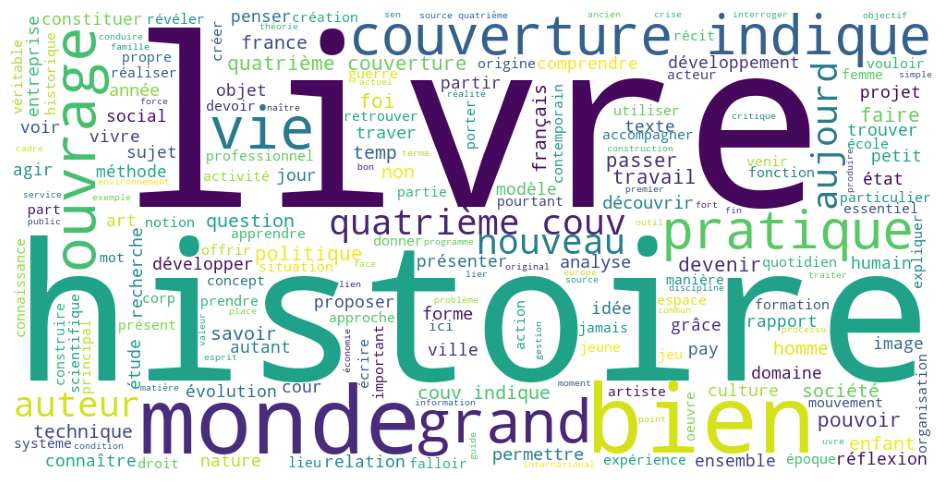

In [115]:
plot_wordcloud(df_sample['RESUME_processed'])

In [116]:
# Vectorization
feature = 'RESUME_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df_sample[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (20000, 300)


In [117]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [118]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.013096 -0.080936       1        1  12.198182
10    -0.110097 -0.036208       2        1  11.991998
13     0.013224 -0.085885       3        1  11.706643
14    -0.112997 -0.043738       4        1  10.360063
3     -0.067251  0.048514       5        1   9.072649
6     -0.150008  0.102130       6        1   8.718528
9     -0.115062 -0.009374       7        1   6.707184
2      0.000121 -0.026585       8        1   5.681313
5     -0.079839 -0.103636       9        1   5.026535
4      0.134220 -0.162446      10        1   3.517031
1     -0.065084 -0.079129      11        1   3.475715
0      0.111284 -0.117270      12        1   3.463799
12     0.432462  0.048454      13        1   3.096641
7      0.095230  0.291408      14        1   2.681852
8     -0.073108  0.254702      15        1   2.301867, topic_info=                   Term        Freq       Total Category  logprob  loglift
83               enfant  613.000000  613.000000  Default  30.0000  30.0000
76                droit  611.000000  611.000000  Default  29.0000  29.0000
62           couverture  546.000000  546.000000  Default  28.0000  28.0000
63   couverture indique  464.000000  464.000000  Default  27.0000  27.0000
224           quatrième  620.000000  620.000000  Default  26.0000  26.0000
..                  ...         ...         ...      ...      ...      ...
260              social   13.623195  468.465914  Topic15  -4.8765   0.2338
208             pouvoir   11.050733  374.668415  Topic15  -5.0858   0.2479
261             société   10.518819  355.591496  Topic15  -5.1351   0.2508
26               auteur   11.021253  501.132006  Topic15  -5.0884  -0.0456
273             travail   10.689058  425.694289  Topic15  -5.1190   0.0869

[631 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.111787        4èm
0         2  0.127031        4èm
0         3  0.132112        4èm
0         4  0.096543        4èm
0         5  0.015244        4èm
...     ...       ...        ...
299       7  0.057476  évolution
299       8  0.053371  évolution
299       9  0.086215  évolution
299      10  0.106742  évolution
299      11  0.008211  évolution

[2665 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 14, 15, 4, 7, 10, 3, 6, 5, 2, 1, 13, 8, 9])

In [119]:
pyLDAvis.save_html(p, os.path.join(fig_path, "pyldavis_resumes_lemma.html"))

## Exploration des description (titre+ resumé)

In [122]:
# Preproces des résumés
df_sample['DESCR_processed'] = df_sample['DESCR'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

In [123]:
# Exemple
idx = 6549
print("Description brute: \n", df_sample['DESCR'].iloc[idx])
print("\nDescription après processing :\n", df_sample['DESCR_processed'].iloc[idx])

Description brute: 
 Dix de der Décembre 1944, quelque part dans les Ardennes belges, lors de la grande offensive des armées dHitler. Au pied dun calvaire mutilé par les bombardements...

Description après processing :
 der décembre 1944 part ardenne belge grand offensive armée hitler pied calvair mutiler bombardement


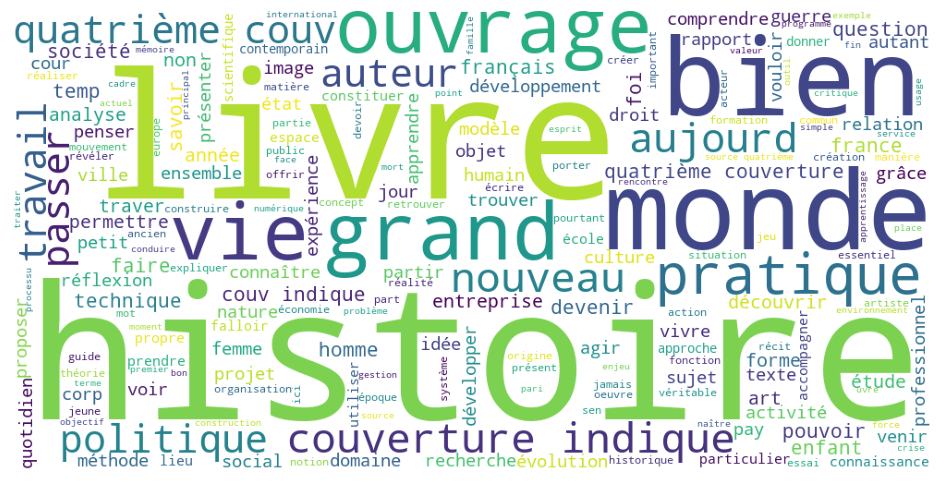

In [124]:
plot_wordcloud(df_sample['DESCR_processed'])

In [125]:
# Vectorization
feature = 'DESCR_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df_sample[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (20000, 300)


In [126]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [127]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.089408  0.021648       1        1  13.638063
13    -0.152316  0.012400       2        1  12.384760
14    -0.112946  0.037940       3        1  10.970749
11    -0.124020  0.057893       4        1  10.721629
8     -0.112958 -0.007586       5        1   9.287581
3     -0.047600  0.091982       6        1   8.214655
9     -0.135213  0.024123       7        1   7.584100
2     -0.123444  0.024981       8        1   6.072719
10    -0.095906 -0.027939       9        1   5.242265
5     -0.119362  0.019904      10        1   3.944971
12     0.394125  0.170862      11        1   2.899312
4      0.388738  0.177278      12        1   2.714944
6     -0.046497 -0.008856      13        1   2.537506
7      0.183589 -0.319648      14        1   2.085295
0      0.193219 -0.274982      15        1   1.701451, topic_info=          Term        Freq       Total Category  logprob  loglift
82      enfant  816.000000  816.000000  Default  30.0000  30.0000
270        the  443.000000  443.000000  Default  29.0000  29.0000
224  quatrième  685.000000  685.000000  Default  28.0000  28.0000
129    indique  655.000000  655.000000  Default  27.0000  27.0000
61        couv  510.000000  510.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
12     analyse    0.418082  331.293773  Topic15  -8.0530  -2.6014
128  important    0.222779  154.356319  Topic15  -8.6825  -2.4672
216  programme    0.226029  184.109084  Topic15  -8.6680  -2.6289
203      place    0.223951  270.272469  Topic15  -8.6772  -3.0221
204      point    0.223772  279.155116  Topic15  -8.6780  -3.0552

[620 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.159883        4èm
0         2  0.148857        4èm
0         3  0.066159        4èm
0         4  0.143344        4èm
0         6  0.121291        4èm
...     ...       ...        ...
299       6  0.165956  évolution
299       7  0.069876  évolution
299       8  0.048040  évolution
299      10  0.026204  évolution
299      13  0.004367  évolution

[2454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 14, 15, 12, 9, 4, 10, 3, 11, 6, 13, 5, 7, 8, 1])

In [128]:
pyLDAvis.save_html(p, os.path.join(fig_path, "pyldavis_description_lemma.html"))

# Exploration TEF labels